In [1]:
import csv
import matplotlib.pyplot as plt

scales = []
times = []

with open('data_loading_times.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        if row['Error']:
            print(f"Error at scale {row['ScaleGB']}GB: {row['Error']}")
        else:
            scales.append(int(row['ScaleGB']))
            times.append(float(row['TimeTakenSeconds']))

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(scales, times, marker='o')
plt.title('Data Loading Time vs Scale')
plt.xlabel('Scale (GB)')
plt.ylabel('Time Taken (seconds)')
plt.grid(True)
plt.savefig('data_loading_times_plot.png')
plt.show()


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Configuration: files to read for load test
output_files = [
    ('results_scale_1.txt', '1 GB'),
    ('results_scale_3.txt', '3 GB'),
    ('results_scale_5.txt', '5 GB'),
    ('results_scale_7.txt', '7 GB')
]

# Function to read and aggregate data from multiple scale files
def aggregate_power_test_data(output_files):
    load_data = []
    for file_name, scale in output_files:
        df = pd.read_csv(file_name, sep=",", header=None)
        df.columns = ["query", "time"]
        
        # Convert execution time to float and aggregate total time per file
        df['time'] = df['time'].apply(lambda x: float(str(x).split("s")[0]))
        total_time = df['time'].sum()
        
        load_data.append({"scale": scale, "time": total_time})
    
    # Convert to DataFrame
    df_load = pd.DataFrame(load_data)
    return df_load

# Plot function for load test
def plot_load_test(df_load, output_path):
    fig, ax = plt.subplots()
    fig.set_size_inches(5, 5, forward=True)
    
    # Plot execution time per scale
    plt.plot(df_load["scale"], df_load["time"], '-o', color="skyblue", label="Power Test")
    
    # Add grid, average line, and labels
    ax.grid(linestyle='--')
    plt.legend()

    plt.ylabel("Execution Time (s)")
    plt.xlabel("Scale (GB)")
    plt.savefig(output_path, format="png", bbox_inches='tight')
    plt.show()

# Usage
df_load_test = aggregate_power_test_data(output_files)
plot_load_test(df_load_test, 'power_test_total_gb.png')


In [13]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def create_df_from_csv(path_in):
    """
    Reads a CSV file and processes it into a DataFrame with 'query' and 'time' columns.
    """
    df = pd.read_csv(path_in, sep=",", header=None)
    df.columns = ["query", "time"]
    
    # Extract the numeric part of the 'query' column (e.g., "query_1.sql" -> 1)
    df['query'] = df['query'].apply(lambda x: int(re.search(r'query_(\d+)\.sql', str(x)).group(1)) if re.search(r'query_(\d+)\.sql', str(x)) else None)
    
    # Drop any rows where 'query' could not be parsed to an integer
    df = df.dropna(subset=['query'])
    df['query'] = df['query'].astype(int)
    
    # Process 'time' column to convert to float
    df['time'] = df['time'].apply(lambda x: float(str(x).split("s")[0]))  # Converts time to float
    df = df.sort_values('query')
    return df

def plot_queries_time(path_in, path_out):
    """
    Plots a horizontal bar chart of query execution times.
    
    Parameters:
    - path_in: str, path to input CSV file
    - path_out: str, path to save the output plot image
    """
    # Load and process data
    df = create_df_from_csv(path_in)
    y = df["query"]
    width = df["time"]
    
    # Print total execution time
    print(f"{path_in} - Total Execution Time: {np.sum(width):.2f}s")
    
    # Plot setup
    fig, ax = plt.subplots(figsize=(20, 25))
    bars = ax.barh(y, width, color="skyblue", align='center', zorder=2)
    
    # Add bar labels and grid
    ax.bar_label(bars)
    ax.invert_yaxis()  # Reverse y-axis for better readability
    ax.grid(linestyle='--', zorder=0)

    # Ensure all query numbers are visible on the y-axis
    ax.set_yticks(y)
    ax.set_yticklabels(y, fontsize=10)

    # Add average execution time line
    plt.axvline(np.average(width), color='#6ac482', label="Average Execution Time(s)", zorder=3)
    
    # Labels and formatting
    plt.legend()
    plt.ylabel("Query", fontsize=25)
    plt.xlabel("Execution Time (s)", fontsize=25)
    plt.title("Query Execution Times", fontsize=30)
    plt.tight_layout()
    
    # Save and display plot
    plt.savefig(path_out, format="png", bbox_inches='tight')
    plt.show()

# List of input and output file pairs for each scale
scale_files = [
    ("results_scale_1.txt", "query_execution_times_scale_1.png"),
    ("results_scale_3.txt", "query_execution_times_scale_3.png"),
    ("results_scale_5.txt", "query_execution_times_scale_5.png"),
    ("results_scale_7.txt", "query_execution_times_scale_7.png")
]

# Loop through each scale file to create and save plots
for input_file, output_file in scale_files:
    plot_queries_time(input_file, output_file)


In [21]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# List of output files and corresponding scales
output_files = [
    ('throughput_scale_1.txt', '1 GB'),
    ('throughput_scale_3.txt', '3 GB'),
    ('throughput_scale_5.txt', '5 GB'),
    ('throughput_scale_7.txt', '7 GB')
]

# Dictionary to store total execution time per scale
scale_total_durations = {}

for output_file, scale in output_files:
    if not os.path.isfile(output_file):
        print(f"Output file {output_file} not found.")
        continue

    try:
        # Read data skipping the first line (Total duration)
        df = pd.read_csv(output_file, skiprows=1)
        # Assign column names
        df.columns = ['ClientID', 'QueryFile', 'Status', 'ExecutionTime']
        # Ensure ExecutionTime is numeric
        df['ExecutionTime'] = pd.to_numeric(df['ExecutionTime'], errors='coerce')
        # Remove rows with NaN ExecutionTime
        df = df.dropna(subset=['ExecutionTime'])
        # Convert ClientID to int
        df['ClientID'] = df['ClientID'].astype(int)
        # Group by ClientID and sum ExecutionTime per client
        client_totals = df.groupby('ClientID')['ExecutionTime'].sum()
        # The total execution time is the maximum total time among clients
        total_execution_time = client_totals.max()
        scale_total_durations[scale] = total_execution_time
    except Exception as e:
        print(f"Error processing file {output_file}: {e}")
        continue

# Sort scales for consistent plotting
sorted_scales = sorted(scale_total_durations.keys(), key=lambda x: int(x.split()[0]))
total_durations = [scale_total_durations[scale] for scale in sorted_scales]

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(sorted_scales, total_durations, marker='o', linestyle='-', color='skyblue')
plt.xlabel('Scale')
plt.ylabel('Total Execution Time (seconds)')
plt.title('Total Execution Time by Data Warehouse Scale')
plt.grid(True)
plt.tight_layout()
plt.show()


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Paths to the output files
power_test_file = 'results_scale_7.txt'
throughput_test_file = 'throughput_scale_7.txt'

# 1. Read the Power Test Data
try:
    df_power = pd.read_csv(power_test_file, header=None, names=['QueryFile', 'PowerExecutionTime'])
except Exception as e:
    print(f"Error reading power test file: {e}")
    exit(1)

# Ensure 'PowerExecutionTime' is numeric
df_power['PowerExecutionTime'] = pd.to_numeric(df_power['PowerExecutionTime'], errors='coerce')

# 2. Read the Throughput Test Data
try:
    with open(throughput_test_file, 'r') as f:
        lines = f.readlines()
    # Skip the first line (Total duration) and read the rest
    throughput_data = lines[1:]  # This assumes the first line is 'Total duration: ...'

    # Create a DataFrame from the data
    from io import StringIO
    throughput_content = ''.join(throughput_data)
    df_throughput = pd.read_csv(StringIO(throughput_content), header=0)
except Exception as e:
    print(f"Error reading throughput test file: {e}")
    exit(1)

# Ensure the columns are named correctly
df_throughput.columns = ['ClientID', 'QueryFile', 'Status', 'ExecutionTime']

# Convert 'ExecutionTime' to numeric
df_throughput['ExecutionTime'] = pd.to_numeric(df_throughput['ExecutionTime'], errors='coerce')

# Filter out unsuccessful queries
df_throughput = df_throughput[df_throughput['Status'] == 'success']

# 3. Compute average execution times per query in the throughput test
df_throughput_avg = df_throughput.groupby('QueryFile')['ExecutionTime'].mean().reset_index()
df_throughput_avg.rename(columns={'ExecutionTime': 'ThroughputExecutionTime'}, inplace=True)

# 4. Merge the data on 'QueryFile'
df_comparison = pd.merge(df_power, df_throughput_avg, on='QueryFile')

# Remove any NaN values
df_comparison.dropna(inplace=True)

# Sort the DataFrame by 'QueryFile'
df_comparison.sort_values('QueryFile', inplace=True)

# 5. Plot the Data
# Set up the positions and width for the bars
ind = np.arange(len(df_comparison))  # the x locations for the groups
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 8))

# Plot bars for the power test execution times
power_bars = ax.bar(ind - width/2, df_comparison['PowerExecutionTime'], width, label='Power Test')

# Plot bars for the throughput test execution times
throughput_bars = ax.bar(ind + width/2, df_comparison['ThroughputExecutionTime'], width, label='Throughput Test')

# Add labels, title, and legend
ax.set_xlabel('Query Files')
ax.set_ylabel('Execution Time (seconds)')
ax.set_title('Comparison of Query Execution Times: Power Test vs. Throughput Test (Scale 7)')
ax.set_xticks(ind)
ax.set_xticklabels(df_comparison['QueryFile'], rotation=90)
ax.legend()

# Function to add labels on top of each bar
def autolabel(rects):
    """Attach a text label above each bar displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),  # Offset text by 3 points vertically
                    textcoords='offset points',
                    ha='center', va='bottom')

autolabel(power_bars)
autolabel(throughput_bars)

plt.tight_layout()
plt.show()


In [22]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Configuration: files to read for power and throughput tests
power_test_files = [
    ('results_scale_1.txt', '1 GB'),
    ('results_scale_3.txt', '3 GB'),
    ('results_scale_5.txt', '5 GB'),
    ('results_scale_7.txt', '7 GB')
]

throughput_test_files = [
    ('throughput_scale_1.txt', '1 GB'),
    ('throughput_scale_3.txt', '3 GB'),
    ('throughput_scale_5.txt', '5 GB'),
    ('throughput_scale_7.txt', '7 GB')
]

# Function to read and aggregate data from multiple scale files
def aggregate_test_data(output_files, test_type):
    load_data = []
    for file_name, scale in output_files:
        if not os.path.isfile(file_name):
            print(f"File {file_name} not found.")
            continue

        if test_type == 'power':
            # Read the power test data
            df = pd.read_csv(file_name, sep=",", header=None)
            df.columns = ["query", "time"]
            
            # Convert execution time to float and aggregate total time per file
            df['time'] = pd.to_numeric(df['time'], errors='coerce')
            total_time = df['time'].sum()
            
        elif test_type == 'throughput':
            # Read the throughput test data, skipping the first line (Total duration)
            with open(file_name, 'r') as f:
                lines = f.readlines()
            if len(lines) < 2:
                print(f"File {file_name} does not contain enough data.")
                continue
            # Read the rest of the data into a DataFrame
            from io import StringIO
            data = ''.join(lines[1:])  # Skip the first line
            df = pd.read_csv(StringIO(data), header=0)
            df.columns = ['ClientID', 'QueryFile', 'Status', 'ExecutionTime']
            # Ensure ExecutionTime is numeric
            df['ExecutionTime'] = pd.to_numeric(df['ExecutionTime'], errors='coerce')
            df = df.dropna(subset=['ExecutionTime'])
            # Convert ClientID to int
            df['ClientID'] = df['ClientID'].astype(int)
            # Group by ClientID and sum ExecutionTime per client
            client_totals = df.groupby('ClientID')['ExecutionTime'].sum()
            # Total execution time is the maximum total execution time among clients
            total_time = client_totals.max()
        else:
            raise ValueError("Invalid test type. Must be 'power' or 'throughput'.")
        
        load_data.append({"scale": scale, "time": total_time})
    
    # Convert to DataFrame
    df_load = pd.DataFrame(load_data)
    return df_load

# Plot function for total execution times
def plot_total_execution_times(df_power, df_throughput, output_path):
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 6, forward=True)
    
    # Ensure scales are sorted consistently
    df_power = df_power.sort_values('scale')
    df_throughput = df_throughput.sort_values('scale')
    
    # Plot execution time per scale
    plt.plot(df_power["scale"], df_power["time"], '-o', color="blue", label="Power Test")
    plt.plot(df_throughput["scale"], df_throughput["time"], '-o', color="orange", label="Throughput Test")
    
    # Add grid, legend, and labels
    ax.grid(linestyle='--')
    plt.legend()

    plt.ylabel("Total Execution Time (seconds)")
    plt.xlabel("Scale")
    plt.title("Total Execution Time per Scale for Power and Throughput Tests")
    plt.savefig(output_path, format="png", bbox_inches='tight')
    plt.show()

# Usage
df_power_test = aggregate_test_data(power_test_files, test_type='power')
df_throughput_test = aggregate_test_data(throughput_test_files, test_type='throughput')
plot_total_execution_times(df_power_test, df_throughput_test, 'power_vs_throughput_total_time.png')


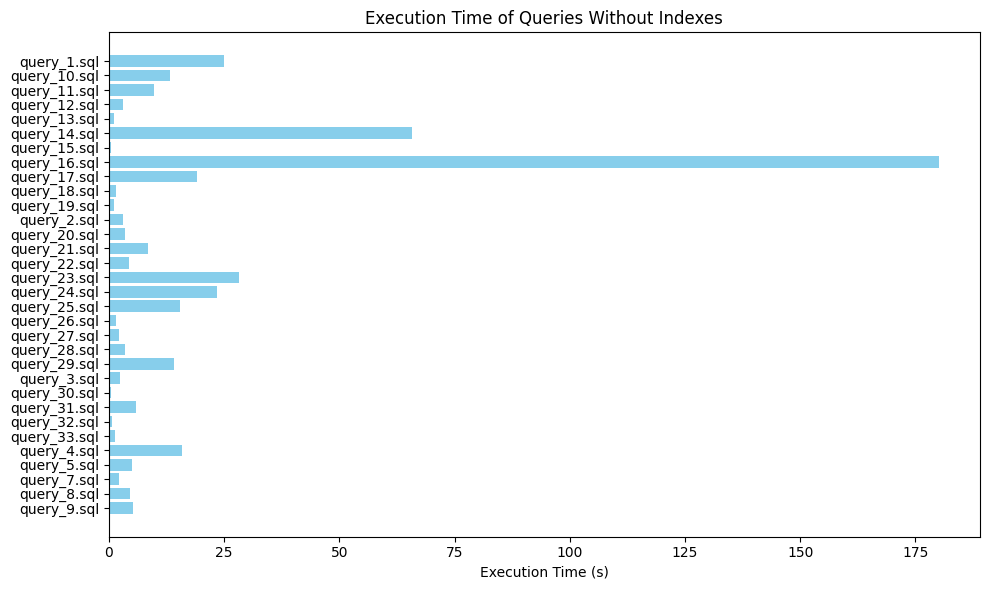

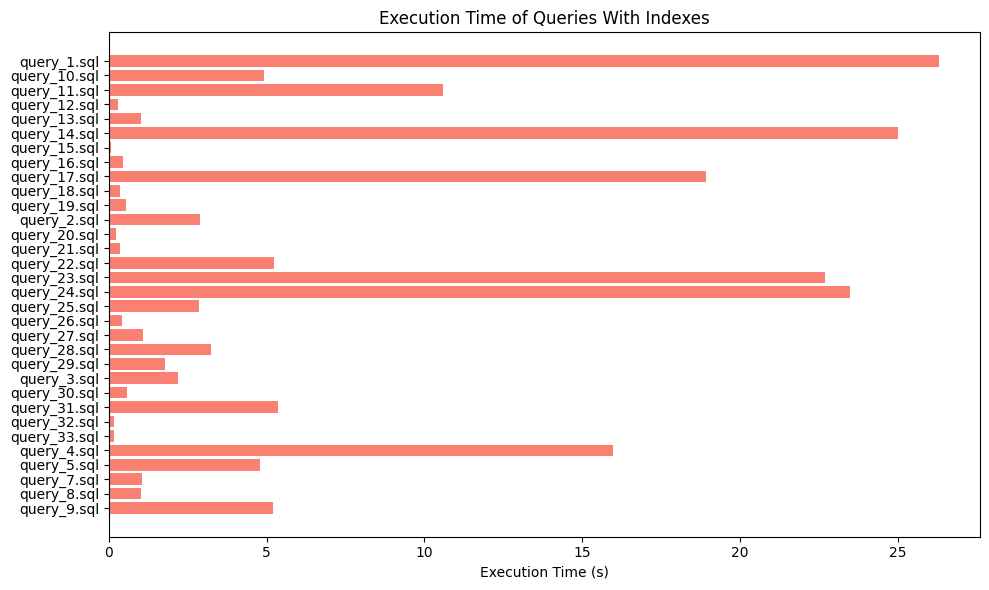

In [2]:
import matplotlib.pyplot as plt
import csv

# Function to plot the results
def plot_results(no_index_times, index_times):
    query_files = list(no_index_times.keys())
    no_index_vals = [no_index_times[q] for q in query_files]
    index_vals = [index_times[q] for q in query_files]

    # Plot without index
    plt.figure(figsize=(10, 6))
    plt.barh(query_files, no_index_vals, color='skyblue')
    plt.xlabel("Execution Time (s)")
    plt.title("Execution Time of Queries Without Indexes")
    plt.gca().invert_yaxis()  # Invert y-axis for better readability
    plt.tight_layout()
    plt.show()

    # Plot with index
    plt.figure(figsize=(10, 6))
    plt.barh(query_files, index_vals, color='salmon')
    plt.xlabel("Execution Time (s)")
    plt.title("Execution Time of Queries With Indexes")
    plt.gca().invert_yaxis()  # Invert y-axis for better readability
    plt.tight_layout()
    plt.show()

# Read the CSV file and store the times in dictionaries
no_index_times = {}
index_times = {}

with open('index_test_results.csv', 'r') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)  # Skip the header row
    for row in reader:
        query = row[0]
        no_index_time = float(row[1])
        index_time = float(row[2])
        no_index_times[query] = no_index_time
        index_times[query] = index_time

# Call the function to plot the results
plot_results(no_index_times, index_times)
